# Hybrid A* 原理与代码

> Refs:
> - [Paper | Dmitri Dolgov, et. al. Practical Search Techniques in Path Planning for Autonomous Driving](https://www.aaai.org/Papers/Workshops/2008/WS-08-10/WS08-10-006.pdf)
> - [Python Code on github | PythonRobotics/Hybrid A*](https://github.com/Alexbeast-CN/PythonRobotics/tree/master/PathPlanning/HybridAStar)

## 1. 简介

Hybrid A* 是 2004 年 DARPA 城市挑战中的冠军车队使用的全局导航算法。相比与传统的 A* 算法，Hybrid A* 将由基于栅格地图的四邻域，八邻域的节点拓展方式，更换为了符合车辆动力学 (Kinodynamics) 的运动轨迹：

<center>

![拓展方式](./pics/expansion.png)

</center>

为什么我们需要 Kinodynamics 呢？因为车辆运动学模型的限制，车辆无法按照 A* 所生成的路径行走。例如如下图所示的情况，车辆最初的朝向是向下的，而 A* 的路径则是从障碍物的上方绕过去的。由于转弯半径的限制，这样的路径是无法跟随，而 Hybrid A* 则会考虑到车辆初始方向和终点方向，以及每一次节点拓展都符合车辆的运动学，因此生成的路径一定是车辆可以跟随的。

<center>

![A* 与 Hybrid A* 路径对比](./pics/Whykino.png)

</center>

## 2. 算法流程与实现


### 2.1 车辆的运动模型与碰撞模型

Ackman 底盘的汽车可以简化为一个两轮的自行车模型：

<center>

![自行车模型](./pics/kinematicsmodel.png)

</center>

该模型的运动学表达式为：

$$
\begin{align*}
  &\dot{x} = v \cos \psi \\
  &\dot{y} = v \sin \psi \\
  &\dot{\psi} = \frac{v}{l_f + l_r} \tan \delta
\end{align*}
$$

其中，$v$ 为车辆的线速度，$\psi$ 为车辆的朝向角，$\delta$ 为车辆的转向角，$l_f$ 为前轮距离车辆重心的距离，$l_r$ 为后轮距离车辆重心的距离。

其 Python 实现如下：

In [1]:
from math import cos, sin, tan, pi

def pi_2_pi(angle):
    return (angle + pi) % (2 * pi) - pi

def move(x, y, yaw, distance, steer, L):
    x += distance * cos(yaw)
    y += distance * sin(yaw)
    yaw += pi_2_pi(distance * tan(steer) / L)  # distance/2

    return x, y, yaw

假设现在有一辆车，其几何信息为：

- 宽度 W = 2m
- 前后轮的距离 WB = 3m
- 后轮到车最前端的距离为 LF = 3.3m
- 后轮到车最后端的距离为 LB = 1m
- 最大转向角为 $\pm$ pi/5
- 车辆的圆心与后轮相距 BUBBLE_DIST = (LF - LB) / 2
- 圆的半径为  BUBBLE_R = $\sqrt{}$ ((LF + LB) / 2)^2 + (W / 2)^2

```python

In [7]:
import numpy as np
import matplotlib.pyplot as plt

WB = 3.0  # rear to front wheel
W = 2.0  # width of car
LF = 3.3  # distance from rear to vehicle front end
LB = 1.0  # distance from rear to vehicle back end
MAX_STEER = pi/5  # [rad] maximum steering angle

BUBBLE_DIST = (LF - LB) / 2.0  # distance from rear to center of vehicle.
BUBBLE_R = np.hypot((LF + LB) / 2.0, W / 2.0)  # bubble radius

# vehicle rectangle vertices
VRX = [LF, LF, -LB, -LB, LF]
VRY = [W / 2, -W / 2, -W / 2, W / 2, W / 2]

由于车辆的运动轨迹只由质点表示，因此还需要对每一个路径点进行额外的碰撞检测。首先我们利用 [KDtree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) 获取车辆外接圆范围内的所有障碍物，然后对障碍物检查是否在车辆的矩形内。

下面的代码可以画出如下图所示的车辆碰撞检测模型:

In [13]:
def plot_arrow(x, y, yaw, length=1.0, width=0.5, fc="r", ec="k"):
    """Plot arrow."""
    if not isinstance(x, float):
        for (i_x, i_y, i_yaw) in zip(x, y, yaw):
            plot_arrow(i_x, i_y, i_yaw)
    else:
        plt.arrow(x, y, length * cos(yaw), length * sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width, alpha=0.4)

def rot_mat_2d(angle):
    return np.array([[cos(angle), -sin(angle)],
                     [sin(angle), cos(angle)]])
    
def plot_car(x, y, yaw):
    car_color = '-k'
    c, s = cos(yaw), sin(yaw)
    rot = rot_mat_2d(-yaw)
    car_outline_x, car_outline_y = [], []
    for rx, ry in zip(VRX, VRY):
        converted_xy = np.stack([rx, ry]).T @ rot
        car_outline_x.append(converted_xy[0]+x)
        car_outline_y.append(converted_xy[1]+y)
        
    arrow_x, arrow_y, arrow_yaw = c * 1.5 + x, s * 1.5 + y, yaw
    plot_arrow(arrow_x, arrow_y, arrow_yaw)
    plt.plot(car_outline_x, car_outline_y, car_color)
    
def plot_cllision_model(x, y, yaw):
    plot_car(x, y, yaw)
    plt.plot(x,y,marker='o',color='r')
    cx = x + BUBBLE_DIST * cos(yaw)
    cy = y + BUBBLE_DIST * sin(yaw)
    circle1 = plt.Circle((cx, cy), BUBBLE_R, color='r', fill=False)
    plt.gcf().gca().add_artist(circle1)



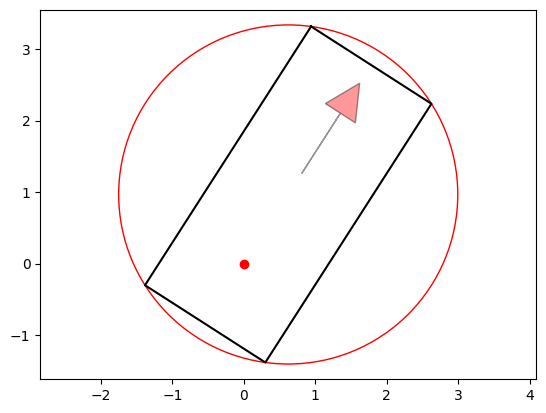

In [14]:
x, y, yaw = 0., 0., 1.
plt.axis('equal')
plot_cllision_model(x, y, yaw)
plt.show()

矩形的碰撞检测，需要先将障碍物的点利用旋转矩阵旋转到车辆坐标系下，然后判断障碍物的点是否在车辆的矩形内。算法代码如下：

In [15]:
def check_car_collision(x_list, y_list, yaw_list, ox, oy, kd_tree):
    for i_x, i_y, i_yaw in zip(x_list, y_list, yaw_list):
        cx = i_x + BUBBLE_DIST * cos(i_yaw)
        cy = i_y + BUBBLE_DIST * sin(i_yaw)

        ids = kd_tree.query_ball_point([cx, cy], BUBBLE_R)

        if not ids:
            continue

        if not rectangle_check(i_x, i_y, i_yaw,
                               [ox[i] for i in ids], [oy[i] for i in ids]):
            return False  # collision

    return True  # no collision


def rectangle_check(x, y, yaw, ox, oy):
    # transform obstacles to base link frame
    rot = rot_mat_2d(yaw)
    for iox, ioy in zip(ox, oy):
        tx = iox - x
        ty = ioy - y
        converted_xy = np.stack([tx, ty]).T @ rot
        rx, ry = converted_xy[0], converted_xy[1]

        if not (rx > LF or rx < -LB or ry > W / 2.0 or ry < -W / 2.0):
            return False  # no collision

    return True  # collision

### 2.2 地图与节点

#### 2.2.1 地图

对于任何机器人来说，地图都是有精度的，该精度与地图的尺度有关。通常机器人会储存两个以上的地图，一个尺度较大的地图，用于全局路径规划，但精度低。一个尺度较小的地图，用于局部路径规划，精度高。由于 Hybrid A* 是一个全局路径规划算法，所以这里所使用的地图精度为 2m。地图的角度精度为 5 度。所以，传感器得到的每一个障碍物点信息，以及机器人的位置和角度信息都会以整数的形式储存在地图上。

In [ ]:
XY_GRID_RESOLUTION = 2.0  # [m]
YAW_GRID_RESOLUTION = np.deg2rad(5.0)  # [rad]

x_ind = round(x / XY_GRID_RESOLUTION)
y_ind = round(y / XY_GRID_RESOLUTION)
yaw_ind = round(yaw / YAW_GRID_RESOLUTION)

#### 2.2.2 节点与拓展

与所有的图搜索算法一样，路径的搜索需要通过拓展节点来完成。由于节点的拓展方式是通过模拟车辆的匀速运动得到的，因此这里除了需要记录车辆当前的位姿信息 (x, y , yaw) 之外，还需要记录一些运动信息，如当前是正向还是逆向运动 (direction)，方向盘的转动角度 (steer)。此外还为了计算最短路径的参数，如到当前节点的 cost, 以及本节点的父节点。剩下的参数会在后文解释。

In [ ]:
class Node:

    def __init__(self, x_ind, y_ind, yaw_ind, direction,
                 x_list, y_list, yaw_list, directions,
                 steer=0.0, parent_index=None, cost=None):
        self.x_index = x_ind
        self.y_index = y_ind
        self.yaw_index = yaw_ind
        self.direction = direction
        self.x_list = x_list
        self.y_list = y_list
        self.yaw_list = yaw_list
        self.directions = directions
        self.steer = steer
        self.parent_index = parent_index
        self.cost = cost

如第一节所述，Hybrid A* 使用车辆的运动学模型来拓展节点，起拓展方式如下图所示：

<center>

![节点拓展](./pics/SimComp.png)

</center>

但需要注意的是，节点拓展中的参数对最终路径的好坏有着很重要的作用。首先是对于方向盘角度的采样数量， `N_STEER`, 这决定了一个节点会计算多少次拓展。接下来的 `MOTION_RESOLUTION` 即一个步长，也可以理解为 $v \Delta t$。 一个 `MOTION_RESOLUTION` 并不会计算为一个节点，而是等多个 `MOTION_RESOLUTION` 的长度累计到一个 `arc_l` 之后，才会记录一下一个节点。而一个 `arc_l` 的长度则是略大于一格的长度，这是为了尽量避免两次模拟路径落在同一个格子里。这时再看 `class Node` 中的 `x_list, y_list, yaw_list` 就比较容易理解了，即记录下了两个节点之间的模拟路径点，并这些路径点来检测是否会发生碰撞。

结合上图来看，`N_STEER` 与 `MOTION_RESOLUTION` 越大，则生成的轨迹越连续，越小则越离散，但于此同时，计算量就越大。因此需要根据地图的尺寸和类型来修改参数。如果地图比较空旷，我们则允许模拟轨迹稍微稀疏一点，反之则希望轨迹稠密。

接下来看一下节点拓展的代码：

In [ ]:
N_STEER = 20              # number of steer command
MOTION_RESOLUTION = 0.08  # [m] path interpolate resolution

def calc_motion_inputs():
    for steer in np.concatenate((np.linspace(-MAX_STEER, MAX_STEER,
                                             N_STEER), [0.0])):
        for d in [1, -1]:
            yield [steer, d]

def get_neighbors(current, config, ox, oy, kd_tree):
    for steer, d in calc_motion_inputs():
        node = calc_next_node(current, steer, d, config, ox, oy, kd_tree)
        # Check if the node is inside the map and not collide with obstacles.
        if node and verify_index(node, config):
            yield node


def calc_next_node(current, steer, direction, config, ox, oy, kd_tree):
    x, y, yaw = current.x_list[-1], current.y_list[-1], current.yaw_list[-1]

    arc_l = XY_GRID_RESOLUTION * 1.5
    x_list, y_list, yaw_list = [], [], []
    
    # Simulate about one grid in length.
    # put all the intermediate points into the list.
    for _ in np.arange(0, arc_l, MOTION_RESOLUTION):
        x, y, yaw = move(x, y, yaw, MOTION_RESOLUTION * direction, steer)
        x_list.append(x)
        y_list.append(y)
        yaw_list.append(yaw)

    # Make sure there is no collision along the way.
    if not check_car_collision(x_list, y_list, yaw_list, ox, oy, kd_tree):
        return None

    d = direction == 1
    # Use the last point as the next node.
    x_ind = round(x / XY_GRID_RESOLUTION)
    y_ind = round(y / XY_GRID_RESOLUTION)
    yaw_ind = round(yaw / YAW_GRID_RESOLUTION)

### 2.3 Cost

Cost 在 A* 中被用于指引方向和加速搜索的。在 Hybrid A* 中，依然会使用 Heuristic Cost 来指引搜索方向，但除此之外，还增加了很多其他的 Cost 用于控制路径的质量。

#### 2.3.1 Heuristic Cost and Traveled Cost

Heuristic Cost 和 Traveled Cost 都是用于计算路径长度的。其中 Heuristic Cost 是当前到终点的一个估计长度，而 Traveled Cost 则是机器人从起点到当前点真实路径的长度。

如果你熟悉 A* 的话，你会知道常用的Heuristic Cost 的计算方式有 L1 和 L2 距离。在 Hybrid A* 中也可以使用 L2 距离，此外，还可以选择 [Reeds-shepp Path](http://lavalle.pl/planning/node822.html) 和 [Dubins Path](http://lavalle.pl/planning/node821.html)（在后文中会有讲解）。为了减小 Heuristic Cost 的计算量，通常会在计算过程中会忽略掉图中的障碍物。由此得到的当前点到终点的距离值往往是小于真实值的，但这并不影响。 由于在节点拓展的过程中，一个格子可能会被重复拓展，所以可以事先用 bfs 创建一个 heuristic cost lookup table，有时也可以减少一些计算量。

#### 2.3.2 Map Cost

熟悉 ROS 的同学对于 Cost Map 应该都不陌生，在 ROS 中，我们会用不同的数字来表示该栅格的信息，比如：

- UNKNOWN          = 255,
- OBSTACLE         = 254,
- INFLATE_OBSTACLE = 253,
- FREE_SPACE       = 1,


除此之外，我们还希望当路径两侧都有障碍物的时候，车辆可以尽量行驶在路的中间。因此我们对障碍物再次做膨胀，但这一次对膨胀区域进行递减计算，使其在越靠近障碍物的地方，其 Cost 就越大。这样的操作不仅可以优化路径，还一定程度上减小了节点拓展中像墙上拓展的可能性，从而减少计算量。

<center>

![Voronoi.png](./pics/Voronoi.png)

</center>

#### 2.3.3 Motion Cost

为了尽可能的走出圆滑的路线，我们对一些不好的节点拓展方式设置了惩罚因素：

- SB_COST 切换正逆向行驶惩罚
- BACK_COST 倒车惩罚
- STEER_CHANGE_COST  与上一个节点的方向盘角度不一致惩罚
- NON_STRAIGHT_COST  方向盘角度非 0 惩罚

除此之外，为了平衡各类惩罚因数，我们还为 Heuristic Cost 以及 Map Cost 乘上一个倍率： `H_COST`, `M_COST`。假如我们感觉算法的计算速度太慢了，则可以保持其他参数不变的情况下，增加 `H_COST`，这样生成的路线就会更偏向传统 A* 的路线。如果生成的路线是歪歪扭扭的，则可以适当增加 `STEER_CHANGE_COST` 以及 `NON_STRAIGHT_COST`。但值得注意的一点是，我们增加了某一个因素的权重，意味着减小了其他因素的权重。

In [ ]:
SB_COST = 100.0          # switch back penalty cost
BACK_COST = 50.0         # backward penalty cost
STEER_CHANGE_COST = 2.0  # steer angle change penalty cost
NON_STRAIGHT_COST = 0.0  # steer angle not zero cost
H_COST = 3.0             # Heuristic cost
M_COST = 3.0             # Cost map coeffient


def calc_next_node(current, steer, direction, config, ox, oy, kd_tree):
    x, y, yaw = current.x_list[-1], current.y_list[-1], current.yaw_list[-1]

    arc_l = XY_GRID_RESOLUTION * 1.5
    x_list, y_list, yaw_list = [], [], []
    
    # Simulate about one grid in length.
    # put all the intermediate points into the list.
    for _ in np.arange(0, arc_l, MOTION_RESOLUTION):
        x, y, yaw = move(x, y, yaw, MOTION_RESOLUTION * direction, steer)
        x_list.append(x)
        y_list.append(y)
        yaw_list.append(yaw)

    # Make sure there is no collision along the way.
    if not check_car_collision(x_list, y_list, yaw_list, ox, oy, kd_tree):
        return None

    d = direction == 1
    # Use the last point as the next node.
    x_ind = round(x / XY_GRID_RESOLUTION)
    y_ind = round(y / XY_GRID_RESOLUTION)
    yaw_ind = round(yaw / YAW_GRID_RESOLUTION)

    # Calculate the cost base on the actions.
    added_cost = 0.0

    if d != current.direction:
        added_cost += SB_COST

    # steer penalty
    added_cost += NON_STRAIGHT_COST * abs(steer)

    # steer change penalty
    added_cost += STEER_CHANGE_COST * abs(current.steer - steer)

    # cost = huristic cost + motion cost + traveled cost
    cost = current.cost + added_cost + arc_l

    node = Node(x_ind, y_ind, yaw_ind, d, x_list,
                y_list, yaw_list, [d],
                parent_index=calc_index(current, config),
                cost=cost, steer=steer)

    return node

### 2.4 One shot 

还记得之前提到的 Heuristic 的计算方式吗？之前我们提到，Heuristic 的计算都是不考虑地图障碍物的，如果在这种情况下生成出路径恰好又不会发生碰撞，那我们就可以直接使用了。这样就大大减少了节点拓展的计算量。但如果要直接使用这段路径，那么就要求 Heuristic 的计算方式符合车辆的运动学约束，而 Dubins Path 和 Reeds Shepp Path 就恰好符合车辆的运动学约束。

#### 2.4.1 Dubins Path

> 推荐视频： [Youtube 视频 | Coding a Dubins Car Optimal Path Planner](https://www.youtube.com/watch?v=tjUVE3jto98&ab_channel=AaronBecker)

<center>

![Dubins Path](./pics/Dubins.png)

</center>

Dubins Path 就是将点到点的最优路径规划划分为了三段路径，这三段路径分为由：直行(S)，左转(L)，右转(R)，这三种运动方式组成。将三个动作进行组合，则共有 6 种不同的路径模型：

$$\{LRL, RLR, LSL, LSR, RSL, RSR\}$$

<center>

![Dubins Path Demo](./pics/Dubins2.png)

</center>

算法的流程如下：

1. 获取起点和终点的位姿信息 (x, y, yaw)，以及车辆的最小转弯半径。
2. 按照最小转弯半径在车的两侧画两个圆圈
3. 根据不同的运动模式来计算路径，比如运动模式为 LSR 则分别选择起点左边的圆圈以及终点右边的圆圈，以及两个圆的切线。
4. 接下来需要确定每一段路径的长度，还是以 LSR 为例。L 的长度为 $\alpha$，S 的长度为 $d$，R 的长度为 $\beta$
5. 为了方便计算，我们先把终点的位置转换到起点的坐标系下，然后进行如下方代码所示的计算
6. 为了找到最优路径，我们通常需要尝试所有六种模式，并计算其路径的长度，最终返回长度最短的那一条。

In [ ]:
from math import *

def _dubins_path_planning_from_origin(dx, dy, end_yaw, curvature):
    d = hypot(dx, dy) * curvature
    theta = _mod2pi(atan2(dy, dx))
    alpha = _mod2pi(-theta)
    beta = _mod2pi(end_yaw - theta)
    
    return _LSR(alpha, beta, d)
    

def _mod2pi(x):
    return x % (2 * np.pi)

def _calc_trig_funcs(alpha, beta):
    sin_a = sin(alpha)
    sin_b = sin(beta)
    cos_a = cos(alpha)
    cos_b = cos(beta)
    cos_ab = cos(alpha - beta)
    return sin_a, sin_b, cos_a, cos_b, cos_ab

def _LSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = -2 + d ** 2 + (2 * cos_ab) + (2 * d * (sin_a + sin_b))
    if p_squared < 0:
        return None, None, None
    d1 = sqrt(p_squared)
    tmp = atan2((-cos_a - cos_b), (d + sin_a + sin_b)) - atan2(-2.0, d1)
    d2 = _mod2pi(-alpha + tmp)
    d3 = _mod2pi(-_mod2pi(beta) + tmp)
    return d2, d1, d3

这里我就不画图了，完整的代码可以查看 [Github | PythonRobotics/Dubins_Paths](https://github.com/Alexbeast-CN/PythonRobotics/blob/master/PathPlanning/DubinsPath/dubins_path_planner.py)。可以自己在里面尝试着画一画。

#### 2.4.2 Reeds Shepp Path

<center>

![](./pics/Reeds_Shepp.png)

</center>

Reeds Shepp 与 Dubins 类似，但相比于 Dubins 里只允许车辆正向行驶，Reeds Shepp 允许车辆倒车。（使用 | 符号表示倒车）。因此 Reeds Shepp 路径一共有九种情况，如下表所示：

<center>

![Reeds Sheep Paths](./pics/Reeds_Shepp9.png)

</center> 

算法流程这里就不再解释了，可以查看 [Github | PythonRobotics/Reeds Shepp](https://github.com/Alexbeast-CN/PythonRobotics/blob/master/PathPlanning/ReedsSheppPath/reeds_shepp_path_planning.py)

## 3. 路径搜索

Hybrid A* 与 A* 的路径搜索方式一样。都是维护两个列表，一个 OpenList，按 Cost 从小到大的顺序存放节点，因此可以使用优先队列来构建。另一个是 ClosedList 用于存放已经探索过的节点。探索到的每一个新的节点都需要检查一下是否已经存在于 CloseList 中，以免重复探索。因此可以使用 Hash Table 来构建 ClosedList。接下来就是不断的从 OpenList 中取 Cost 最小的节点开始探索，直到探索到终点，或者新的节点可以达成 One Shot 的条件为止。

此部分的代码如下所示：

In [ ]:
def hybrid_a_star_planning(start, goal, ox, oy, xy_resolution, yaw_resolution):
    """
    start: start node
    goal: goal node
    ox: x position list of Obstacles [m]
    oy: y position list of Obstacles [m]
    xy_resolution: grid resolution [m]
    yaw_resolution: yaw angle resolution [rad]
    """

    start[2], goal[2] = rs.pi_2_pi(start[2]), rs.pi_2_pi(goal[2])
    tox, toy = ox[:], oy[:]

    # Speed up the search point process
    obstacle_kd_tree = cKDTree(np.vstack((tox, toy)).T)


    config = Config(tox, toy, xy_resolution, yaw_resolution)

    start_node = Node(round(start[0] / xy_resolution),
                      round(start[1] / xy_resolution),
                      round(start[2] / yaw_resolution), True,
                      [start[0]], [start[1]], [start[2]], [True], cost=0)
    goal_node = Node(round(goal[0] / xy_resolution),
                     round(goal[1] / xy_resolution),
                     round(goal[2] / yaw_resolution), True,
                     [goal[0]], [goal[1]], [goal[2]], [True])

    # openList and closedList only have the index of the node.
    # openList stores the frontier nodes of current search.
    # closedList stores the visited nodes.
    openList, closedList = {}, {}

    # Calculate all free space L2 distance to goal. (BFS)
    # Make it a heuristic lookup table.
    h_dp = calc_distance_heuristic(
        goal_node.x_list[-1], goal_node.y_list[-1],
        ox, oy, xy_resolution, BUBBLE_R)

    # pq is a heap queue that stores the cost and index of the node.
    pq = []
    openList[calc_index(start_node, config)] = start_node
    heapq.heappush(pq, (calc_cost(start_node, h_dp, config),
                        calc_index(start_node, config)))
    final_path = None

    # Just like the triditional A* search:
    # - Expand the node with the lowest cost in the openList.
    # - Add the expanded node to the closedList.
    # - Add the children of current node to the openList.
    while True:
        if not openList:
            print("Error: Cannot find path, No open set")
            return [], [], []

        cost, c_id = heapq.heappop(pq)
        if c_id in openList:
            current = openList.pop(c_id)
            closedList[c_id] = current
        else:
            continue

        if show_animation:  # pragma: no cover
            plt.plot(current.x_list[-1], current.y_list[-1], "xc")
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect(
                'key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
            if len(closedList.keys()) % 10 == 0:
                plt.pause(0.0001)

        is_updated, final_path = update_node_with_analytic_expansion(
            current, goal_node, config, ox, oy, obstacle_kd_tree)

        # If we get one shot path, we can stop searching and return the path.
        if is_updated:
            print("path found")
            break
        
        # expand the node with vehicle kinamatics model.
        for neighbor in get_neighbors(current, config, ox, oy,
                                      obstacle_kd_tree):
            neighbor_index = calc_index(neighbor, config)
            if neighbor_index in closedList:
                continue
            if neighbor not in openList \
                    or openList[neighbor_index].cost > neighbor.cost:
                heapq.heappush(
                    pq, (calc_cost(neighbor, h_dp, config),
                         neighbor_index))
                openList[neighbor_index] = neighbor

    path = get_final_path(closedList, final_path)
    return path